In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from lightgbm import LGBMRegressor, LGBMClassifier

from doubleml.did import DoubleMLDIDMulti
from doubleml.data import DoubleMLPanelData

from doubleml.did.datasets import make_did_CS2021

# simulate data
n_obs = 5000
df = make_did_CS2021(n_obs, dgp_type=4, n_periods=8, n_pre_treat_periods=4, time_type="datetime")
df["ite"] = df["y1"] - df["y0"]

In [2]:
# rename for plotting
df["First Treated"] = df["d"].dt.strftime("%Y-%m").fillna("Never Treated")
df.head()

,id,y,y0,y1,d,t,Z1,Z2,Z3,Z4,ite,First Treated
0,0,208.160364,208.160364,206.150875,2025-07-01,2025-01-01,-1.221552,0.665762,-0.20382,0.617408,-2.009488,2025-07
1,0,204.174392,204.174392,203.462996,2025-07-01,2025-02-01,-1.221552,0.665762,-0.20382,0.617408,-0.711396,2025-07
2,0,199.599967,199.599967,197.741360,2025-07-01,2025-03-01,-1.221552,0.665762,-0.20382,0.617408,-1.858607,2025-07
3,0,195.233663,195.233663,195.721657,2025-07-01,2025-04-01,-1.221552,0.665762,-0.20382,0.617408,0.487994,2025-07
4,0,189.010286,189.010286,191.331624,2025-07-01,2025-05-01,-1.221552,0.665762,-0.20382,0.617408,2.321338,2025-07


In [3]:

# Create aggregation dictionary for means
def agg_dict(col_name):
    return {
        f'{col_name}_mean': (col_name, 'mean'),
        f'{col_name}_lower_quantile': (col_name, lambda x: x.quantile(0.05)),
        f'{col_name}_upper_quantile': (col_name, lambda x: x.quantile(0.95))
    }

# Calculate means and confidence intervals
agg_dictionary = agg_dict("y") | agg_dict("ite")
# convert "d" to month period

# fill NaT values since they are not supported by groupby
agg_df = df.groupby(["t", "First Treated"]).agg(**agg_dictionary).reset_index()
agg_df.head()

,t,First Treated,y_mean,y_lower_quantile,y_upper_quantile,ite_mean,ite_lower_quantile,ite_upper_quantile
0,2025-01-01,2025-05,208.851382,201.215583,216.475755,-0.013452,-2.392223,2.371590
1,2025-01-01,2025-06,210.329416,202.638201,217.961796,-0.052635,-2.448709,2.271408
2,2025-01-01,2025-07,211.793469,204.025050,219.193304,-0.048091,-2.403457,2.219086
3,2025-01-01,2025-08,213.467868,205.879919,220.905510,0.095641,-2.277543,2.263161
4,2025-01-01,Never Treated,215.076606,207.173377,222.389427,-0.009199,-2.332194,2.405225


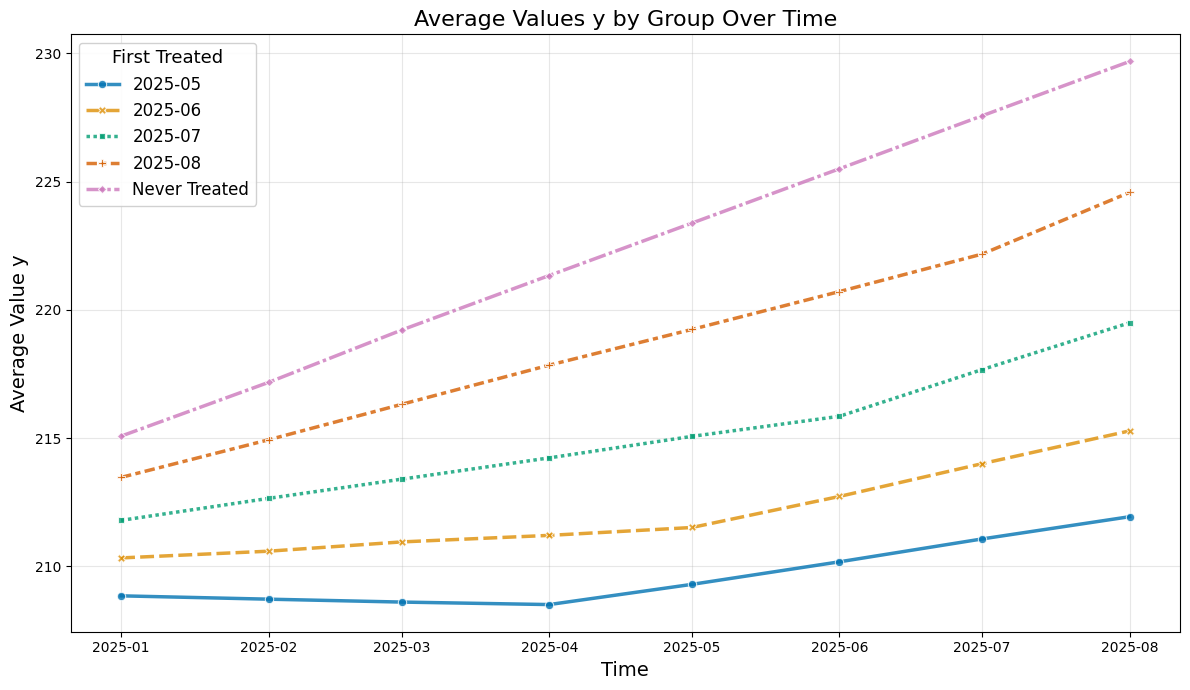

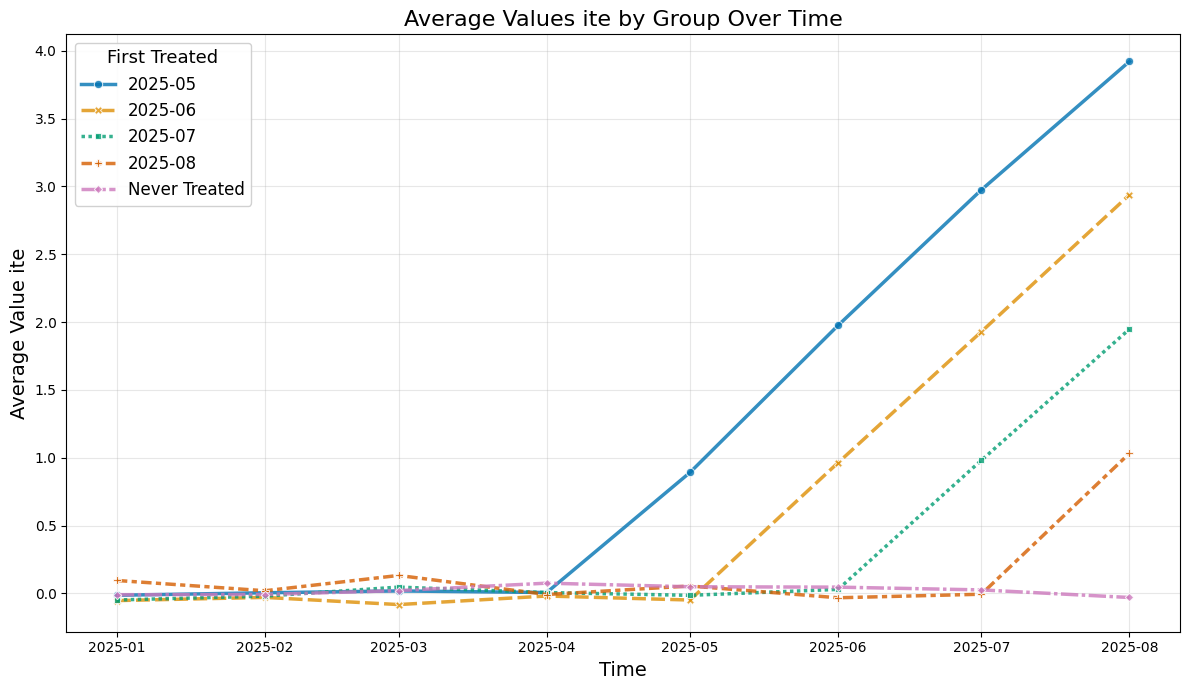

In [4]:
def plot_data_seaborn_improved(df, col_name='y'):
    """
    Create an improved plot with colorblind-friendly features
    
    Parameters:
    -----------
    df : DataFrame
        The dataframe containing the data
    col_name : str, default='y'
        Column name to plot (will use '{col_name}_mean')
    """
    plt.figure(figsize=(12, 7))
    n_colors = df["First Treated"].nunique()
    color_palette = sns.color_palette("colorblind", n_colors=n_colors)

    sns.lineplot(
        data=df,
        x='t',
        y=f'{col_name}_mean',
        hue='First Treated',
        style='First Treated',
        palette=color_palette,
        markers=True,
        dashes=True,
        linewidth=2.5,
        alpha=0.8
    )
    
    plt.title(f'Average Values {col_name} by Group Over Time', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel(f'Average Value {col_name}', fontsize=14)
    

    plt.legend(title='First Treated', title_fontsize=13, fontsize=12, 
               frameon=True, framealpha=0.9, loc='best')
    
    plt.grid(alpha=0.3, linestyle='-')
    plt.tight_layout()

    plt.show()

# Call the function with your dataframes
plot_data_seaborn_improved(agg_df)
plot_data_seaborn_improved(agg_df, col_name='ite')

In [5]:
dml_data = DoubleMLPanelData(df, y_col="y", d_cols="d", id_col="id", t_col="t", x_cols=["Z1", "Z2", "Z3", "Z4"], datetime_unit="M")
print(dml_data)

================== DoubleMLPanelData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['Z1', 'Z2', 'Z3', 'Z4']
Instrument variable(s): None
Time variable: t
Id variable: id
No. Observations: 5000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 12 entries, id to First Treated
dtypes: datetime64[s](2), float64(8), int64(1), object(1)
memory usage: 3.7+ MB



In [6]:
# control_group = "not_yet_treated"
control_group = "never_treated"

gt_combinations = "all"
gt_combinations = "standard"

ml_g = LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=-1)
ml_m = LGBMClassifier(n_estimators=500, learning_rate=0.01, verbose=-1)

dml_obj = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=ml_g,
    ml_m=ml_m,
    gt_combinations=gt_combinations,
    control_group=control_group,
)

dml_obj.fit()
print(dml_obj)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['Z1', 'Z2', 'Z3', 'Z4']
Instrument variable(s): None
Time variable: t
Id variable: id
No. Observations: 5000

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LGBMRegressor(learning_rate=0.01, n_estimators=500, verbose=-1)
Learner ml_m: LGBMClassifier(learning_rate=0.01, n_estimators=500, verbose=-1)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[1.79152793 1.81326944 1.8054232  1.80694168 2.47094152 3.37239486
  4.3303301  1.80638932 1.78492247 1.79906886 1.77017951 1.79014112
  2.5257241  3.38825777 1.79112596 1.7628981  1.80707893 1.82459002
  1.7949473  1.80655601 2.52190091 1.80338096 1.79623925 1.78961074
  1.76971177 1.80947666 1

In [7]:
dml_obj.bootstrap()
dml_obj.sensitivity_analysis()

In [8]:
def create_ci_dataframe(dml_obj, level=0.95, joint=True, include_rvs=False):
    """
    Create a DataFrame with coefficient estimates and confidence intervals from a DoubleML object.
    
    Parameters:
    -----------
    dml_obj : DoubleML object
        The fitted DoubleML object
    level : float, default=0.95
        Confidence level for intervals
    joint : bool, default=True
        Whether to use joint confidence intervals
    
    Returns:
    --------
    DataFrame
        DataFrame containing estimates and confidence intervals
    """

    ci = dml_obj.confint(level=level, joint=joint)

    # Create DataFrame
    result_df = pd.DataFrame({
        'First Treated': [gt_combination[0] for gt_combination in dml_obj.gt_combinations],
        'Pre-treatment Period' : [gt_combination[1] for gt_combination in dml_obj.gt_combinations],
        'Evaluation Period': [gt_combination[2] for gt_combination in dml_obj.gt_combinations],
        'Estimate': dml_obj.coef,
        'CI Lower': ci.iloc[:, 0],
        'CI Upper': ci.iloc[:, 1],
        'Pre-Treatment': [gt_combination[2] < gt_combination[0] for gt_combination in dml_obj.gt_combinations],
    })
    if include_rvs:
        result_df["RV"] = dml_obj.sensitivity_params["rv"]
    return result_df

ci_df = create_ci_dataframe(dml_obj, include_rvs=True)
ci_df.head()

,First Treated,Pre-treatment Period,Evaluation Period,Estimate,CI Lower,CI Upper,Pre-Treatment,RV
"ATT(2025-05,2025-01,2025-02)",2025-05-01,2025-01-01,2025-02-01,-0.126335,-0.511271,0.258601,True,0.040722
"ATT(2025-05,2025-02,2025-03)",2025-05-01,2025-02-01,2025-03-01,0.081016,-0.311316,0.473349,True,0.023928
"ATT(2025-05,2025-03,2025-04)",2025-05-01,2025-03-01,2025-04-01,-0.094349,-0.455328,0.266630,True,0.025671
"ATT(2025-05,2025-04,2025-05)",2025-05-01,2025-04-01,2025-05-01,1.069615,0.673597,1.465633,False,0.246898
"ATT(2025-05,2025-04,2025-06)",2025-05-01,2025-04-01,2025-06-01,1.891446,1.336306,2.446586,False,0.295226


/opt/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


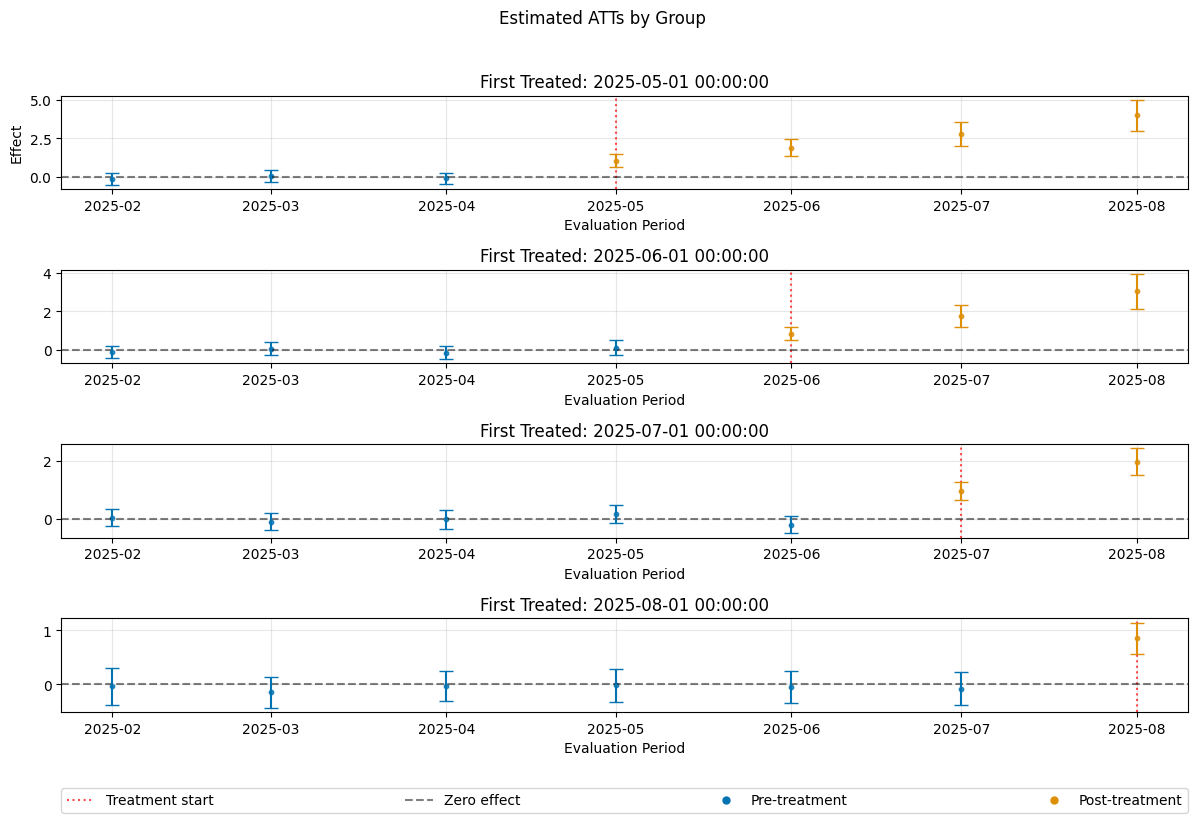

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


def add_jitter(data, is_datetime, jitter_value):
    """
    Adds jitter to duplicate x-values for better visibility.
    
    Args:
        data (DataFrame): The subset of the dataset to jitter.
        is_datetime (bool): Whether the x-values are datetime objects.
        jitter_value (float or timedelta): Jitter amount.

    Returns:
        DataFrame with an additional 'jittered_x' column.
    """
    if data.empty:
        return data
    
    data = data.copy()
    # Initialize jittered_x with original values
    data['jittered_x'] = data['Evaluation Period']
    
    for x_val in data['Evaluation Period'].unique():
        mask = data['Evaluation Period'] == x_val
        count = mask.sum()
        if count > 1:
            # Create evenly spaced jitter values
            if is_datetime:
                jitters = [pd.Timedelta(seconds=float(j)) 
                           for j in np.linspace(-jitter_value, jitter_value, count)]
            else:
                jitters = np.linspace(-jitter_value, jitter_value, count)
                
            # Apply jitter to each duplicate point
            data.loc[mask, 'jitter_index'] = range(count)
            for i, j in enumerate(jitters):
                data.loc[mask & (data['jitter_index'] == i), 'jittered_x'] = x_val + j
    
    return data


def plot_atts(dml_obj, level=0.95, joint=True, figsize=(12, 8)):
    """
    Plots coefficient estimates with confidence intervals over time, grouped by first treated period.
    
    Args:
        dml_obj: The DML object containing estimated treatment effects.
        level (float): Confidence level for the intervals (default 0.95).
        joint (bool): Whether to use joint confidence intervals (default True).
        figsize (tuple): Figure size as (width, height) (default (12, 8)).
    
    Returns:
        None. Displays the plot.
    """
    df = create_ci_dataframe(dml_obj, level=level, joint=joint)
    all_time_periods = sorted(df['Evaluation Period'].unique())
    first_treated_periods = sorted(df['First Treated'].unique())
    n_periods = len(first_treated_periods)
    colors = dict(zip(['pre', 'post'], sns.color_palette("colorblind")[:2]))
    
    is_datetime = pd.api.types.is_datetime64_any_dtype(df['Evaluation Period'])
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(n_periods + 1, 1, height_ratios=[3] * n_periods + [0.5])
    axes = [fig.add_subplot(gs[i]) for i in range(n_periods)]
    if n_periods == 1:
        axes = [axes]
    
    jitter_value = (all_time_periods[1] - all_time_periods[0]).total_seconds() * 0.1 if is_datetime and len(all_time_periods) > 1 else 0.1
    
    for idx, period in enumerate(first_treated_periods):
        period_data = df[df['First Treated'] == period]
        ax = axes[idx]
        i_period = all_time_periods.index(period)
        
        ax.axvline(x=all_time_periods[i_period], color='red', linestyle=':', alpha=0.7)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        pre_treatment = add_jitter(period_data[period_data['Pre-Treatment']], is_datetime, jitter_value)
        post_treatment = add_jitter(period_data[~period_data['Pre-Treatment']], is_datetime, jitter_value)
        
        if not pre_treatment.empty:
            ax.scatter(pre_treatment['jittered_x'], pre_treatment['Estimate'], color=colors['pre'], alpha=0.8, s=10)
            ax.errorbar(pre_treatment['jittered_x'], pre_treatment['Estimate'],
                        yerr=[pre_treatment['Estimate'] - pre_treatment['CI Lower'],
                              pre_treatment['CI Upper'] - pre_treatment['Estimate']],
                        fmt='none', color=colors['pre'], alpha=1.0, capsize=5)
        
        if not post_treatment.empty:
            ax.scatter(post_treatment['jittered_x'], post_treatment['Estimate'], color=colors['post'], alpha=0.8, s=10)
            ax.errorbar(post_treatment['jittered_x'], post_treatment['Estimate'],
                        yerr=[post_treatment['Estimate'] - post_treatment['CI Lower'],
                              post_treatment['CI Upper'] - post_treatment['Estimate']],
                        fmt='none', color=colors['post'], alpha=1.0, capsize=5)
        
        ax.set_title(f'First Treated: {period}')
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.set_ylabel('Effect')
        ax.set_xlabel('Evaluation Period')
    
    legend_ax = fig.add_subplot(gs[-1])
    legend_ax.axis('off')
    legend_elements = [
        Line2D([0], [0], color='red', linestyle=':', alpha=0.7, label='Treatment start'),
        Line2D([0], [0], color='black', linestyle='--', alpha=0.5, label='Zero effect'),
        Line2D([0], [0], marker='o', color=colors['pre'], linestyle='None', label='Pre-treatment', markersize=5),
        Line2D([0], [0], marker='o', color=colors['post'], linestyle='None', label='Post-treatment', markersize=5),
    ]
    legend_ax.legend(handles=legend_elements, loc='center', ncol=5, mode='expand', borderaxespad=0.)
    
    plt.suptitle("Estimated ATTs by Group", y=1.02)
    plt.tight_layout()
    plt.show()

plot_atts(dml_obj, level=0.95, joint=True, figsize=(12, 8))

In [10]:
dml_obj.sensitivity_analysis()
print(dml_obj.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
                              CI lower  theta lower     theta  theta upper  \
ATT(2025-05,2025-01,2025-02) -0.430592    -0.218892 -0.126335    -0.033778   
ATT(2025-05,2025-02,2025-03) -0.229224    -0.020882  0.081016     0.182915   
ATT(2025-05,2025-03,2025-04) -0.399950    -0.204859 -0.094349     0.016161   
ATT(2025-05,2025-04,2025-05)  0.750803     0.955098  1.069615     1.184133   
ATT(2025-05,2025-04,2025-06)  1.433732     1.727613  1.891446     2.055279   
ATT(2025-05,2025-04,2025-07)  2.175267     2.604104  2.796395     2.988686   
ATT(2025-05,2025-04,2025-08)  3.253588     3.809880  3.990323     4.170766   
ATT(2025-06,2025-01,2025-02) -0.365539    -0.189067 -0.093047     0.002972   
ATT(2025-06,2025-02,2025-03) -0.193003  